# Experiments Drawing -> Text

Idea: We want to draw something and then have a neural net reconstruct the code that generated the picture. To make it more interesting, we assume that drawing takes time. This turns it into an n:m translation problem. In fact it should become a "reverse graphics" problem. Now the question is, can we find a big hammer that "just learns" given some noisy and ambiguous input, or do we need a carefully crafted model?

We also want to explore the generative story: Given a part of the input, can the NN fill in the blanks - predict the future etc.

This is supposed to be a simple simulation experiment - in real life, for example we want to describe what's happening in a street scene in a context of 20-30 seconds, with 3D objects and different actors doing things.

Some things I want to look into:
- "classic" MT models like Bahdanau et al's.
- transformers
- DRAW
- generative models
- look at program generation perhaps
- Lecuns paper(s) on prediction
- combinations - can we have a single model that can do both translation and generation?

Also perhaps some other things I would like to get more experience on.
- pytorch. I have surprisingly little (in fact almost no) practical experience with it since most work has been done by people on my team. Especially how to deal with minibatched sequences (masks?)
- fast.ai
- looking into the model to understand more what the parts are doing.

We want to start with a minimal set of things to draw. My initial thought was to use Turtle - the part of the Logo language that deals with drawing things. But hooking a full logo interpreter in seems to be overkill. The main advantage of that would be that it would already have a LISP-like textual representation (see e.g. [here](https://www.calormen.com/jslogo/#).

So what be the most minimal version we could do? I would say

- let's start with "setpos" and "forward"
- let's not even bother with 2D - start with 1D first

Now this will of course constrain the problem a bit too much since there aren't even too many ways to present training data - the model might just memorize all combinations. But if it can't do even that it might not be worth to look further.

# Setup
We first set up a small system that can interpret drawing commands and turn them into primitive animations. We're using a super simple LISP dialect that enables us to a) use expressions in that language as our desired output, b) actually execute them and c) make sure we can later expand our language without much work. 

We use Peter Norvigs article on "LISP in Python" (http://norvig.com/lispy.html) since it contains a LISP interpreter in a few lines of code:

In [1]:
Symbol = str              # A Scheme Symbol is implemented as a Python str
Number = (int, float)     # A Scheme Number is implemented as a Python int or float
Atom   = (Symbol, Number) # A Scheme Atom is a Symbol or Number
List   = list             # A Scheme List is implemented as a Python list
Exp    = (Atom, List)     # A Scheme expression is an Atom or List
def tokenize(chars: str) -> list:
    "Convert a string of characters into a list of tokens."
    return chars.replace('(', ' ( ').replace(')', ' ) ').split()
def parse(program: str) -> Exp:
    "Read a Scheme expression from a string."
    print(program)
    return read_from_tokens(tokenize(program))

def read_from_tokens(tokens: list) -> Exp:
    "Read an expression from a sequence of tokens."
    if len(tokens) == 0:
        raise SyntaxError('unexpected EOF')
    token = tokens.pop(0)
    if token == '(':
        L = []
        while tokens[0] != ')':
            L.append(read_from_tokens(tokens))
        tokens.pop(0) # pop off ')'
        return L
    elif token == ')':
        raise SyntaxError('unexpected )')
    else:
        return atom(token)

def atom(token: str) -> Atom:
    "Numbers become numbers; every other token is a symbol."
    try: return int(token)
    except ValueError:
        try: return float(token)
        except ValueError:
            return Symbol(token)
import math
import operator as op

def standard_env():
    "An environment with some Scheme standard procedures."
    env = {}
    env.update(vars(math)) # sin, cos, sqrt, pi, ...
    env.update({
        '+':op.add, '-':op.sub, '*':op.mul, '/':op.truediv, 
        '>':op.gt, '<':op.lt, '>=':op.ge, '<=':op.le, '=':op.eq, 
        'abs':     abs,
        'append':  op.add,  
        'apply':   lambda proc, args: proc(*args),
        'begin':   lambda *x: x[-1],
        'car':     lambda x: x[0],
        'cdr':     lambda x: x[1:], 
        'cons':    lambda x,y: [x] + y,
        'eq?':     op.is_, 
        'equal?':  op.eq, 
        'length':  len, 
        'list':    lambda *x: list(x), 
        'list?':   lambda x: isinstance(x,list), 
        'map':     lambda *args: list(map(*args)),
        'max':     max,
        'min':     min,
        'not':     op.not_,
        'null?':   lambda x: x == [], 
        'number?': lambda x: isinstance(x, Number),   
        'procedure?': callable,
        'round':   round,
        'symbol?': lambda x: isinstance(x, Symbol),
    })
    return env

global_env = standard_env()
def eval(x: Exp, env=global_env) -> Exp:
    "Evaluate an expression in an environment."
    if isinstance(x, Symbol):        # variable reference
        return env[x]
    elif isinstance(x, Number):      # constant number
        return x                
    elif x[0] == 'if':               # conditional
        (_, test, conseq, alt) = x
        exp = (conseq if eval(test, env) else alt)
        return eval(exp, env)
    elif x[0] == 'define':           # definition
        (_, symbol, exp) = x
        env[symbol] = eval(exp, env)
    else:                            # procedure call
        proc = eval(x[0], env)
        args = [eval(arg, env) for arg in x[1:]]
        return proc(*args)

In [2]:
# Test it!
x = "(begin (define r 10) (* pi (* r r)))"
print(tokenize(x))
eval(parse(x))

['(', 'begin', '(', 'define', 'r', '10', ')', '(', '*', 'pi', '(', '*', 'r', 'r', ')', ')', ')']
(begin (define r 10) (* pi (* r r)))


314.1592653589793

^ We will try to predict streams of tokens like the above
# Drawing functions
So let's introduce a few primitives that allow us to draw. Stick to the most primitive version first - 1D:

In [3]:
import cv2 as cv
import numpy as np
from typing import *

In [4]:
global_env['seq'] = []
h, w = (1, 64)
p = np.array([0, w//2])
d = np.array([0,1]) # direction vector
def curr(): 
    return global_env['seq'][-1]
def new_mat():
    global h, w
    s = global_env['seq']
    if len(s) > 0:
        s.append(np.copy(curr())) 
    else:
        s.append(np.zeros((h,w)))
    return curr()

In [5]:
def clearscreen():
    global_env['seq'] = []
    return new_mat()
def fwd(x):
    global p, d
    if x != 0:
      d[1] = np.sign(x)
      for i in range(0, x, d[1]):
        p += d
        new_mat()[p[0],p[1]] = 1
    return global_env['seq'] 
def setpos(x):
    global p
    p = (0,x)
    return global_env['seq']  

global_env.update({
    'forward': fwd,
    'setpos': setpos,
    'clearscreen': clearscreen
})

In [6]:
x1 = eval(parse("(begin (clearscreen) (setpos 10) (forward 10))"))
x = eval(parse("(begin (clearscreen) (setpos 10) (forward 10))"))

(begin (clearscreen) (setpos 10) (forward 10))
(begin (clearscreen) (setpos 10) (forward 10))


# Visualization
Let's make sure we can introspect the small videos as we introduce them

In [7]:
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [9]:
def show_anim(seq):
  # First set up the figure, the axis, and the plot element we want to animate
  fig, ax = plt.subplots()
  # initialization function: plot the background of each frame
  def init():
    line.set_data([], [])
    return (line,)

  ax.set_xlim((0, w))
  ax.set_ylim((0, h))

  line, = ax.plot([], [], lw=2)
  
  def animate(i):
    img = ax.imshow(np.concatenate((seq[i], seq[i], seq[i])))
    return (img,)
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(seq), interval=20, blit=True)
  return HTML(anim.to_html5_video())


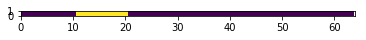

In [10]:
show_anim(x1)

^ how do I get rid of the last output? And how do I show the animation on github?

# A Dataset
As a next step, we generate a bunch of items that we will use as a dataset. Due to the small size of the set we can do at most 64*64 = 4096 examples to cover the whole domain.

In [11]:
import numpy.random
positions = numpy.random.randint(0,64, 1200)
endposition = numpy.random.randint(0,64, 1200)
forwards = endposition - positions

In [12]:
data = [("(begin (clearscreen) (setpos %d) (forward %d))" % (p,f)) for (p,f) in zip(positions,forwards)]


In [13]:
ds = [np.copy(((eval(parse(y))), y)) for y in data]

(begin (clearscreen) (setpos 61) (forward -50))
(begin (clearscreen) (setpos 55) (forward -29))
(begin (clearscreen) (setpos 30) (forward 12))
(begin (clearscreen) (setpos 30) (forward 3))
(begin (clearscreen) (setpos 18) (forward 2))
(begin (clearscreen) (setpos 57) (forward -14))
(begin (clearscreen) (setpos 16) (forward -12))
(begin (clearscreen) (setpos 30) (forward -22))
(begin (clearscreen) (setpos 12) (forward 29))
(begin (clearscreen) (setpos 59) (forward -50))
(begin (clearscreen) (setpos 28) (forward -16))
(begin (clearscreen) (setpos 0) (forward 27))
(begin (clearscreen) (setpos 39) (forward -15))
(begin (clearscreen) (setpos 27) (forward 20))
(begin (clearscreen) (setpos 59) (forward -11))
(begin (clearscreen) (setpos 55) (forward -25))
(begin (clearscreen) (setpos 28) (forward 35))
(begin (clearscreen) (setpos 38) (forward 15))
(begin (clearscreen) (setpos 23) (forward 26))
(begin (clearscreen) (setpos 34) (forward 7))
(begin (clearscreen) (setpos 52) (forward -39))
(begin

(begin (clearscreen) (setpos 40) (forward 14))
(begin (clearscreen) (setpos 55) (forward 6))
(begin (clearscreen) (setpos 45) (forward -25))
(begin (clearscreen) (setpos 25) (forward -21))
(begin (clearscreen) (setpos 24) (forward -1))
(begin (clearscreen) (setpos 19) (forward 44))
(begin (clearscreen) (setpos 52) (forward 6))
(begin (clearscreen) (setpos 5) (forward 13))
(begin (clearscreen) (setpos 53) (forward -42))
(begin (clearscreen) (setpos 38) (forward -26))
(begin (clearscreen) (setpos 53) (forward 1))
(begin (clearscreen) (setpos 19) (forward 20))
(begin (clearscreen) (setpos 26) (forward -21))
(begin (clearscreen) (setpos 25) (forward -18))
(begin (clearscreen) (setpos 53) (forward -43))
(begin (clearscreen) (setpos 44) (forward 15))
(begin (clearscreen) (setpos 57) (forward -14))
(begin (clearscreen) (setpos 28) (forward 32))
(begin (clearscreen) (setpos 46) (forward -32))
(begin (clearscreen) (setpos 12) (forward 35))
(begin (clearscreen) (setpos 62) (forward -43))
(begin 

(begin (clearscreen) (setpos 29) (forward 16))
(begin (clearscreen) (setpos 39) (forward -33))
(begin (clearscreen) (setpos 41) (forward -10))
(begin (clearscreen) (setpos 28) (forward -16))
(begin (clearscreen) (setpos 32) (forward 2))
(begin (clearscreen) (setpos 51) (forward 7))
(begin (clearscreen) (setpos 57) (forward -2))
(begin (clearscreen) (setpos 45) (forward -9))
(begin (clearscreen) (setpos 5) (forward 15))
(begin (clearscreen) (setpos 43) (forward -20))
(begin (clearscreen) (setpos 48) (forward -40))
(begin (clearscreen) (setpos 51) (forward -47))
(begin (clearscreen) (setpos 15) (forward -2))
(begin (clearscreen) (setpos 26) (forward 0))
(begin (clearscreen) (setpos 13) (forward 4))
(begin (clearscreen) (setpos 5) (forward 16))
(begin (clearscreen) (setpos 40) (forward -2))
(begin (clearscreen) (setpos 42) (forward 12))
(begin (clearscreen) (setpos 51) (forward -1))
(begin (clearscreen) (setpos 39) (forward -28))
(begin (clearscreen) (setpos 61) (forward -43))
(begin (cle

In [14]:
(x,y) = zip(*ds)

In [15]:
# padding
x_lengths = list([len(k) for k in x])
max_x = max(x_lengths)
for i in range(len(x)):
  a = x[i]
  while (len(a) < max_x):
    if (len(a) == 0):
       a.append(np.zeros((h,w)))
    a.append(np.copy(a[-1]))

In [16]:
min_x = min([len(k) for k in x])
min_x

64

In [17]:
assert(min_x == max_x)

In [38]:
all_x = np.concatenate(np.expand_dims([np.concatenate(np.expand_dims(k, axis=0)) for k in x], axis=0)) # b:1200,t:64,height:1,width:64

In [39]:
all_x.shape

(1200, 64, 1, 64)

In [40]:
ds[1199][1]

'(begin (clearscreen) (setpos 32) (forward 26))'

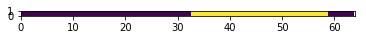

In [44]:
show_anim(all_x[1199])

# The Model
Now that we have the data set up, let's warm up for the actual challenge - training a model that can predict the text. It is already clear that we will have a special challenge there: Predicting the numbers. To be able to do that we'd have to convey the semantics of numbers to the model, which is much less trivial than it appears. In a first attempt we might have to replace a number like 5 with five occurrences of a token.

We start with turning token streams into a form that can be digested by pytorch. This consists of two steps: a) Assigning numbers to tokens and b) embedding them in a word embedding space.
Here's the first step (we're stealing from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html )

In [46]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in tokenize(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [47]:
lang = Lang("code")
for _, l in ds:
    lang.addSentence(l)
EOS_token = "<EOS>"
PAD_token = "<xxpad>"
lang.addWord(EOS_token)
lang.addWord(PAD_token)

The lang object now contains a mapping of every possible token (including the numbers, we'll get to that later) to an index which we use as a vector dimension. Next step is to turn that into an embedding. pytorch has a special "embedding" layer which takes as input an index vector and turns it into an embedding vector of a given size.

In [ ]:
from torch import *
import torch.nn as nn

In [ ]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [ ]:
### First version - 1D input
class EncoderRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input: Tensor, hidden: Tensor) -> Tuple[Tensor, Tensor]:
        # embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.view(input_size, -1)        
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, lang: Lang, embedding_dim: int, lstm_hidden_dim: int, output_dim: int):
        super(DecoderRNN, self).__init__()
        self.lang = lang
        self.num_embeddings = lang.n_words

        self.embedding = nn.Embedding(self.num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim)
        self.out = nn.Linear(lstm_hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input: Tensor, hidden: Tensor) -> (Tensor, Tensor):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder
We are using a standard sequence to sequence decoder with attention (see Bahdanau 2014, https://arxiv.org/abs/1409.0473)

-> LATER. Let's use the above first. We also don't run the images through a ConvNet since we can simply input the 1D-vector.


In [51]:
def indexesFromSentence(lang: Lang, sentence: str) -> Iterable[int]:
    return [lang.word2index[word] for word in tokenize(sentence)]


def tensorFromSentence(lang: Lang, sentence: str):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair: (np.array, str)):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(64, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)


In [58]:
import fastai
import fastai.basic_data
import fastai.basic_train
import fastai.basics
import fastai.train
import torch.utils.data.dataset

In [59]:
def arrayFromSentence(lang: Lang, sentence: str):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(lang.word2index[EOS_token])
    return np.array(indexes)
    #return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
y_all = np.concatenate(np.expand_dims([arrayFromSentence(lang, sent) for sent in y], axis=0))

In [70]:
y_all.shape
torch.Tensor(y_all)[23]

tensor([  2.,   3.,   2.,   4.,   5.,   2.,   6.,  36.,   5.,   2.,   8.,  44.,
          5.,   5., 132.])

In [67]:
# Simple simple version - pad the images + sequence
tds = torch.utils.data.dataset.TensorDataset(torch.Tensor(all_x), torch.Tensor(y_all))

In [ ]:

fastai.basic_data.DataBunch.create(train_ds=torch.utils.data.DataLoader(, valid_ds=)

In [ ]:
fastai.train.Learner()

In [ ]:
l